In [5]:
# Importations des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles et outils d'évaluation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Outils de prétraitement (à réutiliser des notebooks précédents)
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 

# Optimisation des hyperparamètres
# Assurez-vous d'avoir installé Optuna : pip install optuna
import optuna 

# Configuration de la graine aléatoire pour la reproductibilité
RANDOM_STATE = 42

In [6]:
# --- ÉTAPE 1 : CHARGEMENT ET PRÉPARATION DES DONNÉES ET PIPELINE ---

# Simuler le rechargement des données (à adapter avec votre chemin)
# Il est supposé que vous chargez le jeu de données nettoyé et non divisé
df_cleaned = pd.read_csv("../data/preprocessed_data.csv")

X = df_cleaned.drop('Exited', axis=1)
y = df_cleaned['Exited']

# # Séparation des données (réutilisation du split du notebook 03)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
 )

# # Définition des variables numériques et catégorielles (comme dans le notebook 02)
num_var = X_train.select_dtypes(include=np.number).columns.tolist()
cat_var = X_train.select_dtypes(include='object').columns.tolist()

# # Redéfinition du préprocesseur (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
         ('num', StandardScaler(), num_var),           
         ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)
     ]
 )

# Calcul du poids de classe pour gérer l'imbalance (pour XGBoost)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"Taille de l'ensemble d'entraînement : {X_train.shape}")
print(f"Taux de désabonnement (y_train) : {pos_count / len(y_train) * 100:.2f}%")
print(f"Poids de classe (scale_pos_weight) pour XGBoost : {scale_pos_weight:.2f}")

Taille de l'ensemble d'entraînement : (12000, 21)
Taux de désabonnement (y_train) : 19.93%
Poids de classe (scale_pos_weight) pour XGBoost : 4.02


In [8]:
# --- ÉTAPE 2 : OPTIMISATION DES HYPERPARAMÈTRES AVEC OPTUNA ---

def objective(trial, X, y, preprocessor, scale_pos_weight):
    """
    Fonction objectif pour Optuna : définit l'espace de recherche 
    et calcule le score ROC AUC moyen par validation croisée stratifiée.
    """
    
    # 1. Définition de l'espace de recherche
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500), # Plus de profondeur
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2), # Fine-tuning du taux d'apprentissage
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_loguniform('gamma', 1e-7, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-7, 10.0), # L1 Regularization
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-7, 10.0), # L2 Regularization
        
        # Gestion de l'imbalance
        'scale_pos_weight': scale_pos_weight,
        
        # Paramètres fixes
        'random_state': RANDOM_STATE,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # 2. Pipeline et Validation Croisée
    model = XGBClassifier(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    scores = []
    for train_index, val_index in cv.split(X, y):
        # ... (Extraction des folds)
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Entraînement et prédiction de probabilités
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        
        score = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(score)

    return np.mean(scores)

# 3. Exécution de l'étude
# Nombre de trials à ajuster selon le temps de calcul souhaité (100-300 est un bon point de départ)
N_TRIALS = 2 
print(f"Démarrage de l'optimisation Optuna pour {N_TRIALS} essais...")

study = optuna.create_study(direction='maximize') 
study.optimize(lambda trial: objective(trial, X_train, y_train, preprocessor, scale_pos_weight), 
               n_trials=N_TRIALS, 
               show_progress_bar=True)

# Affichage des meilleurs résultats
print("\n" + "="*50)
print("     MEILLEURS RÉSULTATS D'OPTIMISATION (XGBoost)     ")
print("="*50)
print(f"Meilleur ROC AUC CV : {study.best_value:.4f}")
print("Meilleurs Hyperparamètres :")
print(study.best_params)

# Sauvegarder les meilleurs paramètres
best_params = study.best_params

[I 2025-12-06 23:53:14,433] A new study created in memory with name: no-name-2392a26f-88f9-42db-b37b-d7f1a78dfe9d


Démarrage de l'optimisation Optuna pour 2 essais...


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_20336\2278622498.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2), # Fine-tuning du taux d'apprentissage
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_20336\2278622498.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_20336\2278622498.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytr

[I 2025-12-06 23:53:18,739] Trial 0 finished with value: 0.915765976865045 and parameters: {'n_estimators': 459, 'max_depth': 9, 'learning_rate': 0.15577889331377817, 'subsample': 0.830058243878201, 'colsample_bytree': 0.9999646086705933, 'min_child_weight': 7, 'gamma': 1.1008604154024428e-05, 'reg_alpha': 1.018941224600642e-07, 'reg_lambda': 3.661664956426021e-07}. Best is trial 0 with value: 0.915765976865045.


C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_20336\2278622498.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2), # Fine-tuning du taux d'apprentissage
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_20336\2278622498.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_20336\2278622498.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytr

[I 2025-12-06 23:54:01,665] Trial 1 finished with value: 0.9296376942214465 and parameters: {'n_estimators': 1401, 'max_depth': 10, 'learning_rate': 0.006642750341177705, 'subsample': 0.8814477341799887, 'colsample_bytree': 0.7107581367236434, 'min_child_weight': 1, 'gamma': 0.02500073490272529, 'reg_alpha': 0.0009888199613882708, 'reg_lambda': 2.4848758934356716e-06}. Best is trial 1 with value: 0.9296376942214465.

     MEILLEURS RÉSULTATS D'OPTIMISATION (XGBoost)     
Meilleur ROC AUC CV : 0.9296
Meilleurs Hyperparamètres :
{'n_estimators': 1401, 'max_depth': 10, 'learning_rate': 0.006642750341177705, 'subsample': 0.8814477341799887, 'colsample_bytree': 0.7107581367236434, 'min_child_weight': 1, 'gamma': 0.02500073490272529, 'reg_alpha': 0.0009888199613882708, 'reg_lambda': 2.4848758934356716e-06}


In [9]:
# --- ÉTAPE 3 : ENTRAÎNEMENT DU MODÈLE FINAL ---

# Inclure le scale_pos_weight dans les meilleurs paramètres
best_params['scale_pos_weight'] = scale_pos_weight

# Création du classifieur final
final_xgb_model = XGBClassifier(**best_params, 
                                random_state=RANDOM_STATE, 
                                use_label_encoder=False, 
                                eval_metric='logloss')

# Création du pipeline final
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', final_xgb_model)])

# Entraînement sur l'ensemble complet d'entraînement
print("\n=> Entraînement du modèle final optimisé sur X_train...")
final_pipeline.fit(X_train, y_train)
print("=> Entraînement terminé.")


=> Entraînement du modèle final optimisé sur X_train...


c:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Entraînement terminé.



  RAPPORT DE CLASSIFICATION FINAL SUR L'ENSEMBLE DE TEST  
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2402
           1       0.72      0.72      0.72       598

    accuracy                           0.89      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.89      0.89      0.89      3000


F1-Score Final sur Test : 0.7224
ROC AUC Final sur Test : 0.9254


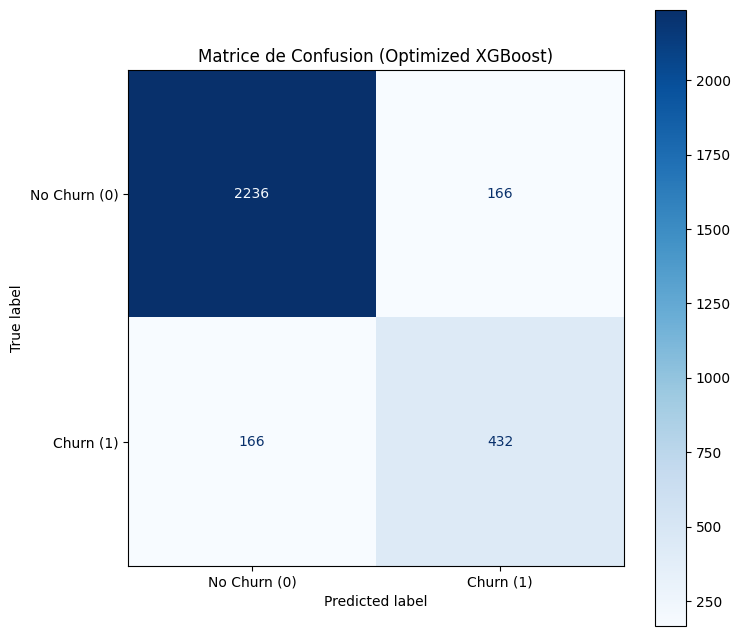

In [10]:
# --- ÉTAPE 4 : ÉVALUATION SUR L'ENSEMBLE DE TEST (X_test) ---

# Prédictions sur l'ensemble de test
y_pred_test = final_pipeline.predict(X_test)
y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]

# 1. Rapport de classification détaillé
print("\n" + "="*50)
print("  RAPPORT DE CLASSIFICATION FINAL SUR L'ENSEMBLE DE TEST  ")
print("="*50)
print(classification_report(y_test, y_pred_test))

# 2. Métriques clés
final_f1 = f1_score(y_test, y_pred_test)
final_roc_auc = roc_auc_score(y_test, y_proba_test)

print(f"\nF1-Score Final sur Test : {final_f1:.4f}")
print(f"ROC AUC Final sur Test : {final_roc_auc:.4f}")

# 3. Matrice de Confusion
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn (0)', 'Churn (1)'])

# Affichage de la matrice de confusion 
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax) 
plt.title("Matrice de Confusion (Optimized XGBoost)")
plt.show()

# Interprétation de la Matrice :
# - True Positives (TP): Les clients qui ont déserté et que le modèle a correctement identifiés.
# - False Negatives (FN): Les clients qui ont déserté mais que le modèle a manqués (à minimiser pour le Recall).

In [11]:
# --- ÉTAPE 5 : SAUVEGARDE DU MODÈLE FINAL ---

import joblib

# Sauvegarde du pipeline complet incluant le pré-traitement et le modèle optimisé
model_filename = '../models/best_model.pkl'
joblib.dump(final_pipeline, f"../models/{model_filename}")

print(f"\nLe pipeline final optimisé a été sauvegardé sous : {model_filename}")

# Note: La prochaine étape (05_deployment.ipynb ou 05_business_impact.ipynb) 
# devrait utiliser ce fichier de modèle sauvegardé.


Le pipeline final optimisé a été sauvegardé sous : ../models/best_model.pkl
